# **Road Vehicle Accident Severity Prediction in Seattle, WA**
---

### Applied Data Science Capstone - IBM/Coursera

### Table of contents

* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

The objective of this project is to predict the severity of a road accident using machine learning models.

These models can be used to explain important factors that influence the severity of the accident. This can be useful for the main target of this project: policymakers aiming at the reduction of the impact caused by these accidents.

The first thing to do is import all the libraries we will use and define some helper functions:

In [1]:
from IPython import display

import pandas as pd
import numpy as np
from cycler import cycler
from matplotlib import pyplot as plt
plt.rc('figure', figsize=(6.4, 4.8))
new_colors = cycler('color', ['#cccccc'])
plt.rc('axes', labelcolor='#666666', titlesize=16, titlepad=20,
       prop_cycle=new_colors.concat(plt.rcParams['axes.prop_cycle']))
plt.rc('axes.spines', left=False, right=False, top=False, bottom=False)
plt.rc('grid', alpha=0)
plt.rc('xtick', bottom=False, color='#666666')
plt.rc('ytick', left=False, color='#666666')
plt.rc('font', size=12)
plt.rc('text', color='#666666')
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from joblib import dump, load

In [2]:
import shap
shap.initjs()

In [3]:
def highlight_rect(rects, v=None, color_min='#55a868', color_max='#c44e52'):
    """Changes colors of the tallest and smallest rects
    v : {'max', 'min'}, default None
        If 'max', highlight only the tallest bar. If 'min', highlight only the
        smallest. Highlight both by default.
    """
    heights = np.empty(len(rects))
    for i, rect in enumerate(rects):
        heights[i] = rect.get_height()

    idx = np.argsort(heights)

    if v != None:
        if v == 'min':
            rects[idx[0]].set_color(color_min)
        elif v == 'max':
            rects[idx[-1]].set_color(color_max)
    else:
        rects[idx[0]].set_color(color_min)
        rects[idx[-1]].set_color(color_max)

In [4]:
def autolabel(rects, percent=True):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if percent == True:
            label = '{:.0f}'.format(height * 100)
        else:
            label = '{}'.format(height)

        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## Data <a name="data"></a>

To try to answer the question, we will use open data from the city of Seattle, which can be dowloaded in the following links:
* [Dataset](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv)
* [Metadata](https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Metadata.pdf)

### Car accidents data

In [5]:
df = pd.read_csv('./data/seattle/Data-Collisions.csv', low_memory=False)

In [6]:
print(df.shape)
with pd.option_context('display.max_columns', None):
    display.display(df.head())

(194673, 38)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [7]:
df.duplicated().value_counts()

False    194673
dtype: int64

There aren't duplicated rows for this dataset.

After loading the data we already see some missing values. We will address this problem before doing any analysis and modeling.

### Address Missing Values

In [8]:
round(df.isnull().sum() / df.shape[0] * 100, 2)

SEVERITYCODE       0.00
X                  2.74
Y                  2.74
OBJECTID           0.00
INCKEY             0.00
COLDETKEY          0.00
REPORTNO           0.00
STATUS             0.00
ADDRTYPE           0.99
INTKEY            66.57
LOCATION           1.38
EXCEPTRSNCODE     56.43
EXCEPTRSNDESC     97.10
SEVERITYCODE.1     0.00
SEVERITYDESC       0.00
COLLISIONTYPE      2.52
PERSONCOUNT        0.00
PEDCOUNT           0.00
PEDCYLCOUNT        0.00
VEHCOUNT           0.00
INCDATE            0.00
INCDTTM            0.00
JUNCTIONTYPE       3.25
SDOT_COLCODE       0.00
SDOT_COLDESC       0.00
INATTENTIONIND    84.69
UNDERINFL          2.51
WEATHER            2.61
ROADCOND           2.57
LIGHTCOND          2.66
PEDROWNOTGRNT     97.60
SDOTCOLNUM        40.96
SPEEDING          95.21
ST_COLCODE         0.01
ST_COLDESC         2.52
SEGLANEKEY         0.00
CROSSWALKKEY       0.00
HITPARKEDCAR       0.00
dtype: float64

Some columns have a lot of missing values. This means they won't be useful for our analysis and prediction, and will be removed together with columns that have little value for us, such as ID's or redundant information.

We are also removing all accidents that are missing the location.

In [9]:
df_clean = df

# remove all accidents wihtout location
df_clean = df_clean.loc[~(df.X.isna() | df.Y.isna())].reset_index(drop=True).copy()

In [10]:
df_clean.drop(columns=['INTKEY',
                       'INCKEY',
                       'LOCATION',
                       'STATUS',
                       'REPORTNO',
                       'COLDETKEY',
                       'OBJECTID',
                       'EXCEPTRSNCODE',
                       'EXCEPTRSNDESC',
                       'INATTENTIONIND',
                       'PEDROWNOTGRNT',
                       'SDOTCOLNUM',
                       'INCDATE',
                       'SPEEDING',
                       'CROSSWALKKEY',
                       'SEGLANEKEY',
                       'SEVERITYCODE.1'], inplace=True)

Removing latitude and longitude values and other location information didn't have a negative impact on the models. It is better to drop these columns so the model can better generalize to other places/cities.

In [11]:
# dropping description columns because they are redundant with code columns,
# location because is redundant with latitude and longitude values,
df_clean = df_clean.loc[:, ~df_clean.columns.str.contains('DESC')]
df_clean.shape

(189339, 18)

We need to check the categorical columns for wrong values and fix them before imputing.

In [12]:
df_clean.loc[:, df_clean.dtypes.eq(np.object)].head()

,ADDRTYPE,COLLISIONTYPE,INCDTTM,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,HITPARKEDCAR
0,Intersection,Angles,3/27/2013 2:54:00 PM,At Intersection (intersection related),N,Overcast,Wet,Daylight,10,N
1,Block,Sideswipe,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),0,Raining,Wet,Dark - Street Lights On,11,N
2,Block,Parked Car,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),0,Overcast,Dry,Daylight,32,N
3,Block,Other,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,23,N
4,Intersection,Angles,1/28/2004 8:04:00 AM,At Intersection (intersection related),0,Raining,Wet,Daylight,10,N


In [13]:
for col in df_clean.loc[:, df_clean.dtypes.eq(np.object)].columns:
    print(f'{col}: {df_clean[col].unique()}\n')

ADDRTYPE: ['Intersection' 'Block']

COLLISIONTYPE: ['Angles' 'Sideswipe' 'Parked Car' 'Other' 'Cycles' 'Rear Ended' 'Head On'
 nan 'Left Turn' 'Pedestrian' 'Right Turn']

INCDTTM: ['3/27/2013 2:54:00 PM' '12/20/2006 6:55:00 PM' '11/18/2004 10:20:00 AM'
 ... '1/19/2019 9:25:00 AM' '1/15/2019 4:48:00 PM' '11/30/2018 3:45:00 PM']

JUNCTIONTYPE: ['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)' 'Driveway Junction'
 'At Intersection (but not related to intersection)'
 'Mid-Block (but intersection related)' nan 'Ramp Junction' 'Unknown']

UNDERINFL: ['N' '0' nan '1' 'Y']

WEATHER: ['Overcast' 'Raining' 'Clear' nan 'Unknown' 'Other' 'Snowing'
 'Fog/Smog/Smoke' 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt'
 'Severe Crosswind' 'Partly Cloudy']

ROADCOND: ['Wet' 'Dry' nan 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']

LIGHTCOND: ['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' nan
 'Unknown' 'Dusk' 'Dawn' 'Dark - 

`INCDTTM` should be of type datetime.

In [14]:
df_clean['INCDTTM'] = pd.to_datetime(df_clean['INCDTTM'])

Converting unknown values to `np.nan`

In [15]:
df_clean.loc[df_clean['JUNCTIONTYPE'].eq('Unknown'), 'JUNCTIONTYPE'] = np.nan
df_clean.loc[df_clean['WEATHER'].eq('Unknown'), 'WEATHER'] = np.nan
df_clean.loc[df_clean['ROADCOND'].eq('Unknown'), 'ROADCOND'] = np.nan
df_clean.loc[df_clean['LIGHTCOND'].eq('Unknown'), 'LIGHTCOND'] = np.nan
df_clean.loc[df_clean['ST_COLCODE'].eq(' '), 'ST_COLCODE'] = np.nan

`UNDERINFL` has multiple labels for the same value.

In [16]:
df_clean['UNDERINFL'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [17]:
df_clean['UNDERINFL'] = df_clean['UNDERINFL'].map({'0': 'N', '1': 'Y', 'N': 'N', 'Y': 'Y'})

In [18]:
round(df_clean.isnull().sum() / df_clean.shape[0] * 100, 2)

SEVERITYCODE     0.00
X                0.00
Y                0.00
ADDRTYPE         0.00
COLLISIONTYPE    2.51
PERSONCOUNT      0.00
PEDCOUNT         0.00
PEDCYLCOUNT      0.00
VEHCOUNT         0.00
INCDTTM          0.00
JUNCTIONTYPE     2.22
SDOT_COLCODE     0.00
UNDERINFL        2.50
WEATHER          9.94
ROADCOND         9.87
LIGHTCOND        9.21
ST_COLCODE       2.51
HITPARKEDCAR     0.00
dtype: float64

We can see that the number of missing values increased to almost 10% in columns of weather, road and light conditions.

Let's see the columns which have missing values and impute them with the most common value:

In [19]:
missing_columns = df_clean.loc[:, df_clean.isna().any()].columns
df_clean[missing_columns].head()

,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE
0,Angles,At Intersection (intersection related),N,Overcast,Wet,Daylight,10
1,Sideswipe,Mid-Block (not related to intersection),N,Raining,Wet,Dark - Street Lights On,11
2,Parked Car,Mid-Block (not related to intersection),N,Overcast,Dry,Daylight,32
3,Other,Mid-Block (not related to intersection),N,Clear,Dry,Daylight,23
4,Angles,At Intersection (intersection related),N,Raining,Wet,Daylight,10


In [20]:
for col in missing_columns:
    imp = SimpleImputer(missing_values = np.nan, strategy='constant', fill_value=df_clean[col].mode())
    df_clean[col] = imp.fit_transform(df_clean[col].to_numpy().reshape(-1, 1))

In [21]:
df_clean.isna().sum().sum()

0

And fix the type of columns which had missing values:

In [22]:
df_clean['ST_COLCODE'] = df_clean['ST_COLCODE'].astype(int)

Categories with low variance may not be useful because they don't have enough data to tell us if the category have a strong enough relationship with our interests, with the target variable.

We are going to manually join them into the 'Other' category for columns that have it.

In [23]:
for i in df_clean.loc[:, df_clean.dtypes.eq(np.object)].columns:
    print(df_clean[i].value_counts(), '\n')

Block           124591
Intersection     64748
Name: ADDRTYPE, dtype: int64 

Parked Car    51138
Angles        34460
Rear Ended    32968
Other         22277
Sideswipe     18034
Left Turn     13624
Pedestrian     6551
Cycles         5378
Right Turn     2912
Head On        1997
Name: COLLISIONTYPE, dtype: int64 

Mid-Block (not related to intersection)              91589
At Intersection (intersection related)               62491
Mid-Block (but intersection related)                 22465
Driveway Junction                                    10580
At Intersection (but not related to intersection)     2071
Ramp Junction                                          143
Name: JUNCTIONTYPE, dtype: int64 

N    180458
Y      8881
Name: UNDERINFL, dtype: int64 

Clear                       127777
Raining                      32015
Overcast                     27136
Snowing                        894
Other                          773
Fog/Smog/Smoke                 553
Sleet/Hail/Freezing Rain       1

In [24]:
weather_lowfreq = ['Partly Cloudy',
                   'Severe Crosswind',
                   'Blowing Sand/Dirt',
                   'Sleet/Hail/Freezing Rain',
                   'Fog/Smog/Smoke']

df_clean['WEATHER'] = df_clean['WEATHER'].apply(lambda x: 'Other' if x in weather_lowfreq else x)

In [25]:
road_lowfreq = ['Standing Water', 'Sand/Mud/Dirt', 'Oil']

df_clean['ROADCOND'] = df_clean['ROADCOND'].apply(lambda x: 'Other' if x in road_lowfreq else x)

In [26]:
light_lowfreq = ['Dark - Unknown Lighting']

df_clean['LIGHTCOND'] = df_clean['LIGHTCOND'].apply(lambda x: 'Other' if x in light_lowfreq else x)

### Feature Engineering

In [27]:
# dropping description columns because they are redundant with code columns,
# location because it didn't had a good impact on model perforamce, hit parked car because
# it is highly correlated with crash type parked car.
X = df_clean.loc[:, ~df_clean.columns.str.contains('DESC')].drop(columns=['SEVERITYCODE',
                                                                          'X',
                                                                          'Y',
                                                                          'HITPARKEDCAR']).copy()
y = df_clean['SEVERITYCODE']

For this data to be input in the models, we need to transform these object columns into numbers using some form of encoding.

In [28]:
X.loc[:, X.dtypes.eq(np.object)].head(1)

,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND
0,Intersection,Angles,At Intersection (intersection related),N,Overcast,Wet,Daylight


Columns with only two values will be converted to 0's and 1's. The others will be one-hot encoded.

In [29]:
for col in X.loc[:, X.dtypes.eq(np.object)].columns:
    print(f'{col}: {X[col].nunique()}')

ADDRTYPE: 2
COLLISIONTYPE: 10
JUNCTIONTYPE: 6
UNDERINFL: 2
WEATHER: 5
ROADCOND: 5
LIGHTCOND: 7


Let's print the `ADDRTYPE` column so we can verify that the encoding is correct

In [30]:
X['ADDRTYPE'].head()

0    Intersection
1           Block
2           Block
3           Block
4    Intersection
Name: ADDRTYPE, dtype: object

Encode the columns using pandas `factorize`

In [31]:
labels = {}

for col in ['ADDRTYPE', 'UNDERINFL']:
    X[col], labels[col] = X[col].factorize(sort=True)

for i in labels:
    labels[i] = dict(enumerate(labels[i]))

In [32]:
X['ADDRTYPE'].head()

0    1
1    0
2    0
3    0
4    1
Name: ADDRTYPE, dtype: int64

With the labels saved in a dictionary, we can convert the columns back to strings easily:

In [33]:
labels['ADDRTYPE']

{0: 'Block', 1: 'Intersection'}

In [34]:
X['ADDRTYPE'].map(labels['ADDRTYPE']).head()

0    Intersection
1           Block
2           Block
3           Block
4    Intersection
Name: ADDRTYPE, dtype: object

Now one-hot encode the remaining categorical variables:

In [35]:
categorical = X.loc[:, X.dtypes.eq(np.object)].columns.values
categorical

array(['COLLISIONTYPE', 'JUNCTIONTYPE', 'WEATHER', 'ROADCOND',
       'LIGHTCOND'], dtype=object)

In [36]:
X = X.join(pd.get_dummies(X[categorical], prefix=['CT', 'JT', 'W', 'R', 'L'], drop_first=True))
X.drop(columns=categorical, inplace=True)

As the time and date features are cyclical, they need a special type of encoding to serve as input for the models.

Sinusoidal encoding makes possible to represent date and time in a format that can be given to models, while keeping the cyclical properties. If you want to know more about click [here](https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/).

We are going to use only the day of week, as the others were not helpful for the models.

In [37]:
# we are going to use only weekday for the models
X['DAY_OF_WEEK'] = X['INCDTTM'].apply(lambda x: x.dayofweek + 1)

In [38]:
X.drop(columns=['INCDTTM'], inplace=True)

In [39]:
days_in_week = 7
X['SIN_DOW'] = np.sin(2 * np.pi * X['DAY_OF_WEEK'] / days_in_week)
X['COS_DOW'] = np.cos(2 * np.pi * X['DAY_OF_WEEK'] / days_in_week)

X.drop(columns=['DAY_OF_WEEK'], inplace=True)

#### Multicollinearity

As we want the models to explain what variables are important on the impact of the accident severity, we need to address multicollinearity.

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [41]:
def color_red(val):
    color = 'red' if val > 5 else 'green'
    return f'color: {color}'

calc_vif(X.loc[:20000, :]).set_index('variables').style.applymap(color_red, subset=['VIF']).set_precision(2)

,VIF
variables,
ADDRTYPE,103.84
PERSONCOUNT,5.53
PEDCOUNT,12.67
PEDCYLCOUNT,52.85
VEHCOUNT,24.55
SDOT_COLCODE,14.31
UNDERINFL,1.13
ST_COLCODE,10.85
CT_Cycles,53.02


In [42]:
def color_red(val):
    color = 'red' if val > 5 else 'green'
    return f'color: {color}'

calc_vif(X.loc[:20000, ~X.columns.str.contains('(SDOT_COLCODE)|(ST_COLCODE)|(JT)|(CT_Cycles)|(CT_Pedestrian)|(L_Dark - Street Lights On)')]).set_index('variables').style.applymap(color_red, subset=['VIF']).set_precision(2)

This pattern has match groups. To actually get the groups, use str.extract.


,VIF
variables,
ADDRTYPE,2.83
PERSONCOUNT,5.49
PEDCOUNT,1.09
PEDCYLCOUNT,1.06
VEHCOUNT,13.50
UNDERINFL,1.11
CT_Head On,1.08
CT_Left Turn,1.36
CT_Other,1.71


In [43]:
X = X.loc[:, ~X.columns.str.contains('(SDOT_COLCODE)|(ST_COLCODE)|(JT)|(CT_Cycles)|(CT_Pedestrian)|(L_Dark - Street Lights On)')]

This is the final input for the models:

In [44]:
print(X.shape)
with pd.option_context('display.max_columns', None):
    display.display(X.head())

(189339, 28)


,ADDRTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,UNDERINFL,CT_Head On,CT_Left Turn,CT_Other,CT_Parked Car,CT_Rear Ended,CT_Right Turn,CT_Sideswipe,W_Other,W_Overcast,W_Raining,W_Snowing,R_Ice,R_Other,R_Snow/Slush,R_Wet,L_Dark - Street Lights Off,L_Dawn,L_Daylight,L_Dusk,L_Other,SIN_DOW,COS_DOW
0,1,2,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0.433884,-0.900969
1,0,2,0,0,2,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0.433884,-0.900969
2,0,4,0,0,3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,-0.433884,-0.900969
3,0,3,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.974928,-0.222521
4,1,2,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0.433884,-0.900969


## Methodology <a name="methodology"></a>

### Exploratory Data Analysis (EDA)

The first important thing to verify is class imbalance.

In [45]:
df_clean['SEVERITYCODE'].map({1: 'Property Damage Only', 2: 'Injury'}).value_counts()

Property Damage Only    132221
Injury                   57118
Name: SEVERITYCODE, dtype: int64

In [46]:
df_clean['SEVERITYCODE'].map({1: 'Property Damage Only', 2: 'Injury'}).value_counts(normalize=True)

Property Damage Only    0.698329
Injury                  0.301671
Name: SEVERITYCODE, dtype: float64

In our case approximately 70% of the cases are of low severity, and only 30% of high severity, but as we have much data, we will simply use the random undersampling technique.

#### Date and time

An interesting thing to see is the evolution of the accidents in time.

In [47]:
print(df_clean['INCDTTM'].min())
print(df_clean['INCDTTM'].max())

2004-01-01 00:00:00
2020-05-20 00:00:00


We got data since 2004 until may 2020. For plotting graphs in the EDA we will remove the year of 2020 because it has incomplete data.

In [48]:
not2020 = ~df_clean['INCDTTM'].astype('string').str.contains('2020')
df_plotting = df_clean['INCDTTM'][not2020].sort_values()

def sel_year(year):
    return df_clean['INCDTTM'].astype('string').str.contains(f'{year}')

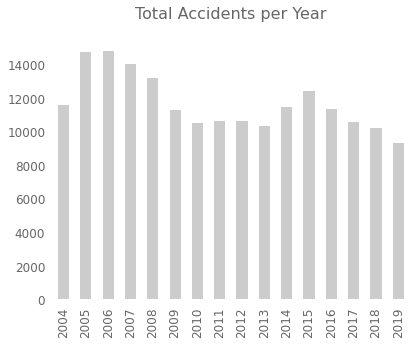

In [49]:
df_plotting.dt.year.value_counts(sort=False).plot.bar()
plt.title('Total Accidents per Year')
plt.show()

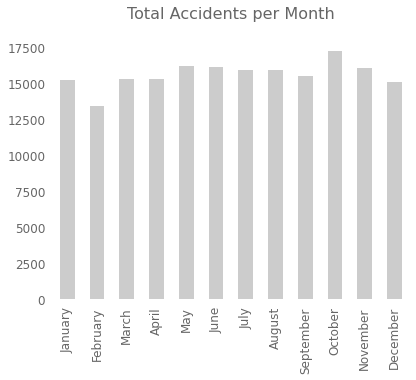

In [50]:
months_plt = df_plotting.dt.month.value_counts(sort=False)
months_plt.index = months_plt.index.map({
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
})
ax = months_plt.plot.bar()
#bars = ax.patches
#highlight_rect(bars, v='max')
plt.title('Total Accidents per Month')
plt.savefig('./report/figures/plot_months.eps', bbox_inches='tight', dpi=300)
plt.show()

There is a noticeable difference between the months of October and February, otherwise the months don't seem to influence much the quantity of accidents, but February has less days than the other months.

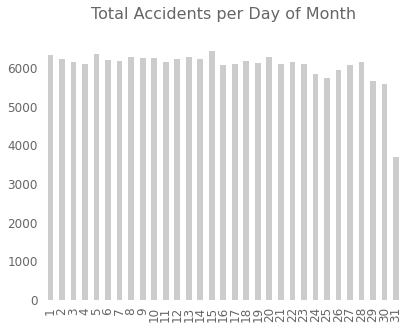

In [51]:
df_clean['INCDTTM'][not2020].dt.day.value_counts(sort=False).plot.bar()
plt.title('Total Accidents per Day of Month')
plt.show()

The day of month don't influence the accidents at all.

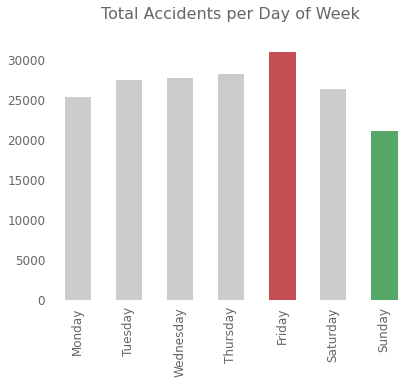

In [52]:
weekdays = df_clean['INCDTTM'][not2020].dt.weekday.value_counts(sort=False)
weekdays.index = weekdays.index.map({0: 'Monday',
                                     1: 'Tuesday',
                                     2: 'Wednesday',
                                     3: 'Thursday',
                                     4: 'Friday',
                                     5: 'Saturday',
                                     6: 'Sunday'})
ax = weekdays.plot.bar()
bars = ax.patches
highlight_rect(bars)
plt.title('Total Accidents per Day of Week')
plt.savefig('./report/figures/plot_day_of_week.eps', bbox_inches='tight', dpi=300)
plt.show()

Around 10 thousand more accidents happened on Friday than on Sunday. More accidents happened on weekdays than on weekends.

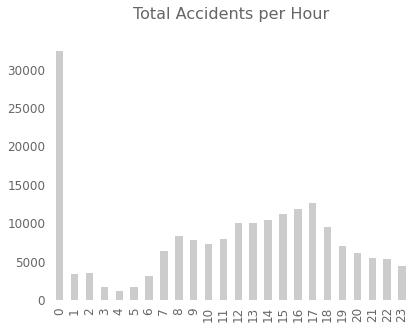

In [53]:
df_clean['INCDTTM'][not2020].dt.hour.value_counts(sort=False).sort_index().plot.bar()
plt.title('Total Accidents per Hour')
plt.savefig('./report/figures/plot_hour.eps', bbox_inches='tight', dpi=300)
plt.show()

One thing we noticed from this graph is that there is still missing values for the hour the accidents happened. Ignoring this problem, we can see that accidents happen more in the afternoon, especially at 5 pm, rush hour.

#### Categorical Variables

We used cross tabulation to visualize the relation between severity and other categorical variables. Keep in mind that we have **70%** of **low severity** and **30%** of **high severity** accidents in total.

In [54]:
sns.set_palette('deep')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


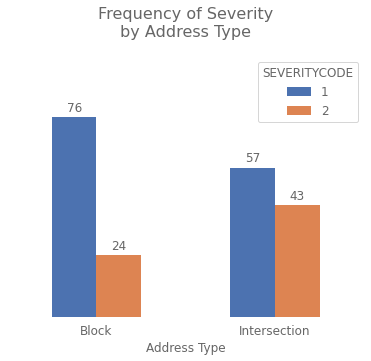

In [55]:
ax = pd.crosstab(df_clean['ADDRTYPE'].rename('Address Type'), y, normalize='index').plot.bar()
plt.title('Frequency of Severity\nby Address Type')
bars = ax.patches
autolabel(bars)
plt.xticks(rotation=0)
plt.yticks([])
plt.ylim(0, 1)
plt.savefig('./report/figures/plot_addrtype.eps', bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


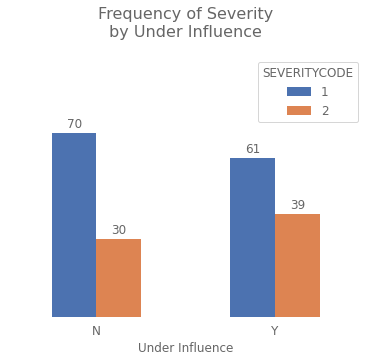

In [56]:
ax = pd.crosstab(df_clean['UNDERINFL'].rename('Under Influence'), y, normalize='index').plot.bar()
plt.title('Frequency of Severity\nby Under Influence')
bars = ax.patches
autolabel(bars)
plt.xticks(rotation=0)
plt.yticks([])
plt.ylim(0, 1)
plt.savefig('./report/figures/plot_underinfl.eps', bbox_inches='tight', dpi=300)
plt.show()

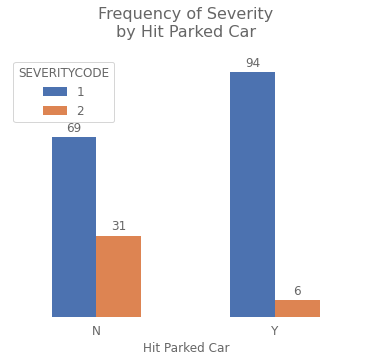

In [57]:
ax = pd.crosstab(df_clean['HITPARKEDCAR'].rename('Hit Parked Car'), y, normalize='index').plot.bar()
plt.title('Frequency of Severity\nby Hit Parked Car')
bars = ax.patches
autolabel(bars)
plt.xticks(rotation=0)
plt.yticks([])
plt.ylim(0, 1)
plt.show()

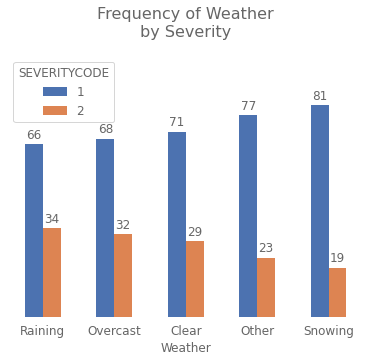

In [58]:
ax = pd.crosstab(df_clean['WEATHER'].rename('Weather'), y, normalize='index').sort_values(2, ascending=False).plot.bar()
bars = ax.patches
autolabel(bars)
plt.title('Frequency of Weather\nby Severity')
plt.xticks(rotation=0)
plt.yticks([])
plt.ylim(0, 1)
plt.show()

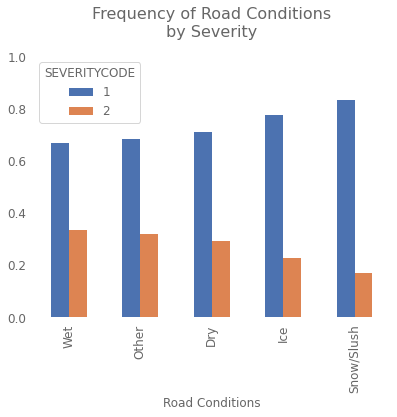

In [59]:
ax = pd.crosstab(df_clean['ROADCOND'].rename('Road Conditions'), y, normalize='index').sort_values(2, ascending=False).plot.bar()
#autolabel(ax.patches)
#plt.yticks([])
plt.title('Frequency of Road Conditions\nby Severity')
plt.ylim(0, 1)
plt.show()

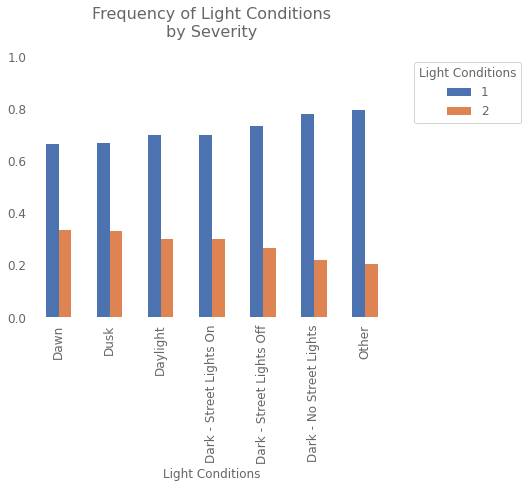

In [60]:
ax = pd.crosstab(df_clean['LIGHTCOND'].rename('Light Conditions'), y, normalize='index').sort_values(2, ascending=False).plot.bar()
#autolabel(ax.patches)
#plt.yticks([])
plt.legend(title='Light Conditions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Frequency of Light Conditions\nby Severity')
plt.ylim(0, 1)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


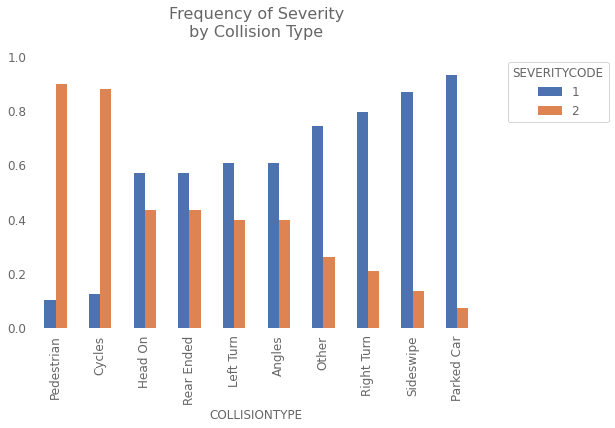

In [61]:
ax = pd.crosstab(df_clean['COLLISIONTYPE'], y, normalize='index').sort_values(2, ascending=False).plot.bar(figsize=(8, 5))
#autolabel(ax.patches)
#plt.yticks([])
plt.legend(title='SEVERITYCODE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Frequency of Severity\nby Collision Type')
plt.ylim(0, 1)
plt.savefig('./report/figures/plot_collisiontype.eps', bbox_inches='tight', dpi=300)
plt.show()

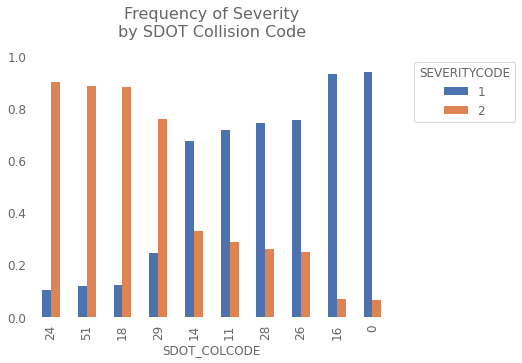

In [62]:
idx = pd.crosstab(df_clean['SDOT_COLCODE'], y).sort_values(2, ascending=False).index
ax = pd.crosstab(df_clean['SDOT_COLCODE'], y, normalize='index').loc[idx[:10], :].sort_values(2, ascending=False).plot.bar()
#autolabel(ax.patches)
#plt.yticks([])
plt.title('Frequency of Severity\nby SDOT Collision Code')
plt.legend(title='SEVERITYCODE', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(0, 1)
plt.show()

### Modeling

We are using a stratified split with 20% of the dataset for testing. We will use the random undersampling technique to train the models.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [64]:
plt.rc('axes.spines', left=True, right=True, top=True, bottom=True)
plt.rc('axes', labelcolor='black')
plt.rc('xtick', bottom=True, color='black')
plt.rc('ytick', left=True, color='black')
plt.rc('text', color='black')

#### Logistic Regression Imbalanced

In [65]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)
print(classification_report(y_test, lr_yhat))

              precision    recall  f1-score   support

           1       0.75      0.96      0.84     26444
           2       0.75      0.28      0.41     11424

    accuracy                           0.75     37868
   macro avg       0.75      0.62      0.63     37868
weighted avg       0.75      0.75      0.71     37868



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


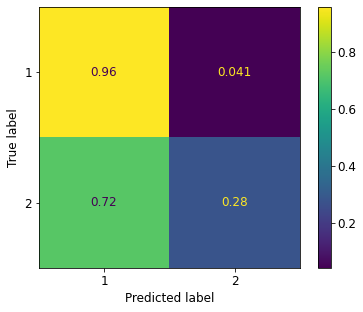

In [66]:
plot_confusion_matrix(lr, X_test, y_test, normalize='true')

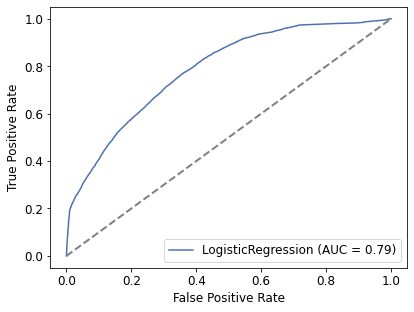

In [67]:
plot_roc_curve(lr, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')

#### Logistic Regression Balanced

In [68]:
lr_bal = Pipeline([
    ('random_sampler', RandomUnderSampler(random_state=42)),
    ('std', StandardScaler()),
    ('lr', LogisticRegression(random_state=42))
])

In [69]:
lr_param = {'lr__C': [1, 10, 100, 1000, 10000]}

lr_search = GridSearchCV(lr_bal, lr_param, n_jobs=-1, cv=3)

In [70]:
lr_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('std', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1, param_grid={'lr__C': [1, 10, 100, 1000, 10000]})

In [71]:
lr_search.best_params_

{'lr__C': 1}

In [72]:
lr_bal_yhat = lr_search.predict(X_test)

In [73]:
print(classification_report(y_test, lr_bal_yhat))

              precision    recall  f1-score   support

           1       0.87      0.61      0.72     26444
           2       0.47      0.79      0.59     11424

    accuracy                           0.67     37868
   macro avg       0.67      0.70      0.65     37868
weighted avg       0.75      0.67      0.68     37868



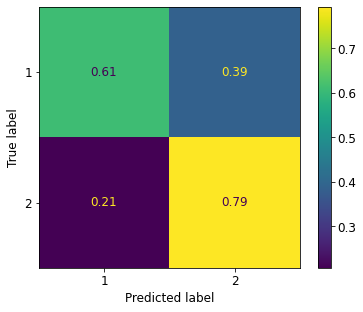

In [74]:
plot_confusion_matrix(lr_search, X_test, y_test, normalize='true')

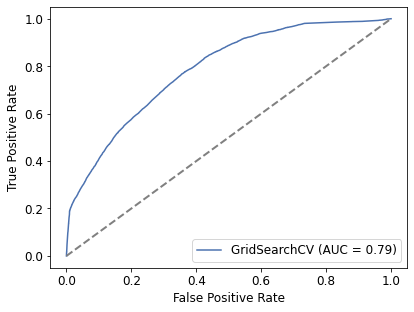

In [75]:
plot_roc_curve(lr_search, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')

#### Random Forest Imbalanced

In [76]:
rf = RandomForestClassifier(random_state=42)

In [77]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [78]:
rf_yhat = rf.predict(X_test)

In [79]:
print(classification_report(y_test, rf_yhat))

              precision    recall  f1-score   support

           1       0.77      0.92      0.83     26444
           2       0.65      0.35      0.46     11424

    accuracy                           0.75     37868
   macro avg       0.71      0.64      0.65     37868
weighted avg       0.73      0.75      0.72     37868



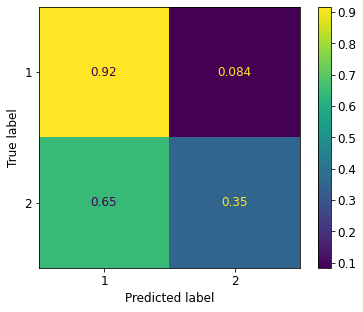

In [80]:
plot_confusion_matrix(rf, X_test, y_test, normalize='true')

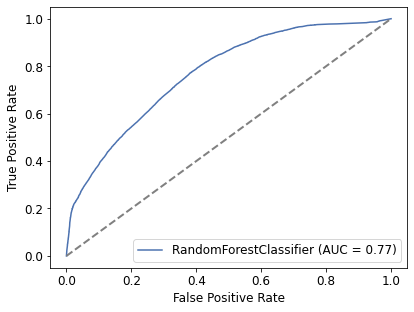

In [81]:
plot_roc_curve(rf, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')

#### Random Forest Balanced

In [82]:
rf_bal = Pipeline([('random_sampler', RandomUnderSampler(random_state=42)),
                   ('std', StandardScaler()),
                   ('rf', RandomForestClassifier(random_state=42))])

In [83]:
rf_param = {'rf__max_depth': [5, 10, None],
            'rf__n_estimators': [200, 300],
            'rf__min_samples_leaf': [5, 20],
            'rf__max_features': ['auto', 'sqrt']}
rf_search = GridSearchCV(rf_bal, rf_param, cv=3, n_jobs=-1)

In [84]:
rf_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('std', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [5, 10, None],
                         'rf__max_features': ['auto', 'sqrt'],
                         'rf__min_samples_leaf': [5, 20],
                         'rf__n_estimators': [200, 300]})

In [85]:
rf_search.best_params_

{'rf__max_depth': None,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__n_estimators': 300}

In [86]:
dump(rf_search, './models/rf.joblib')
#rf_search = load('./models/rf.joblib')

['./models/rf.joblib']

In [87]:
rf_bal_yhat = rf_search.predict(X_test)

In [88]:
print(classification_report(y_test, rf_bal_yhat))

              precision    recall  f1-score   support

           1       0.88      0.61      0.72     26444
           2       0.47      0.81      0.60     11424

    accuracy                           0.67     37868
   macro avg       0.68      0.71      0.66     37868
weighted avg       0.76      0.67      0.69     37868



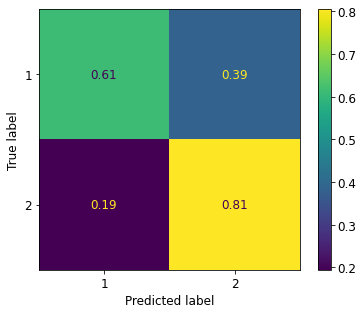

In [89]:
plot_confusion_matrix(rf_search, X_test, y_test, normalize='true')

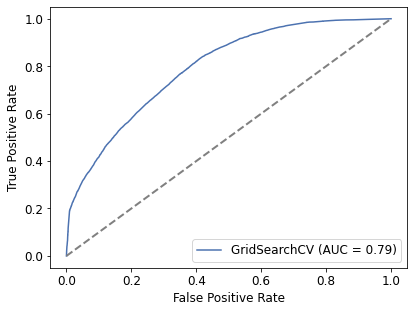

In [90]:
plot_roc_curve(rf_search, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')

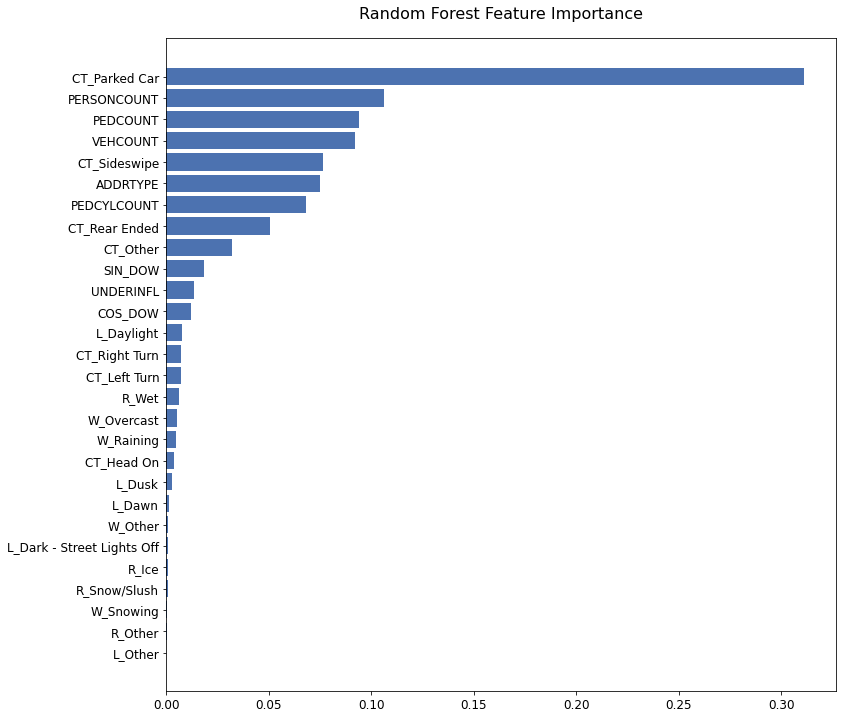

In [91]:
sorted_idx = rf_search.best_estimator_.steps[-1][-1].feature_importances_.argsort()
plt.figure(figsize=(12, 12))
plt.barh(X.columns[sorted_idx], rf_search.best_estimator_.steps[-1][-1].feature_importances_[sorted_idx])
plt.title('Random Forest Feature Importance')
plt.show()

#### XGBoost Imbalanced

In [92]:
xgb = XGBClassifier(random_state=42)

In [93]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [94]:
xgb_yhat = xgb.predict(X_test)

In [95]:
print(classification_report(y_test, xgb_yhat))

              precision    recall  f1-score   support

           1       0.76      0.95      0.85     26444
           2       0.73      0.31      0.43     11424

    accuracy                           0.76     37868
   macro avg       0.75      0.63      0.64     37868
weighted avg       0.75      0.76      0.72     37868



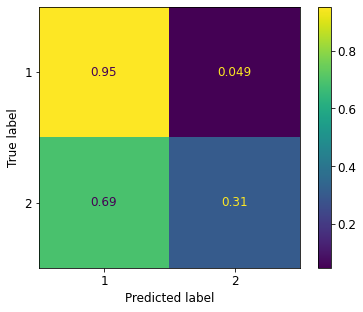

In [96]:
plot_confusion_matrix(xgb, X_test, y_test, normalize='true')

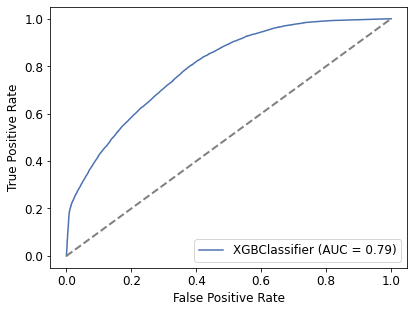

In [97]:
plot_roc_curve(xgb, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')

#### XGBoost Balanced

In [98]:
xgb_bal = Pipeline([
    ('random_sampler', RandomUnderSampler(random_state=42)),
    ('std', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

In [99]:
xgb_param = {'xgb__gamma': [0.5, 1, 2],
             'xgb__max_depth': [3, 6],
             'xgb__n_estimators': [1, 100, 200]}
xgb_search = GridSearchCV(xgb_bal, xgb_param, cv=3)

In [100]:
xgb_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('random_sampler',
                                        RandomUnderSampler(random_state=42)),
                                       ('std', StandardScaler()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                              

In [101]:
dump(xgb_search, './models/xgb.joblib')
#xgb_search = load('./models/xgb.joblib')

['./models/xgb.joblib']

In [102]:
xgb_search.best_params_

{'xgb__gamma': 2, 'xgb__max_depth': 6, 'xgb__n_estimators': 100}

In [103]:
xgb_bal_yhat = xgb_search.predict(X_test)

In [104]:
print(classification_report(y_test, xgb_bal_yhat))

              precision    recall  f1-score   support

           1       0.88      0.61      0.72     26444
           2       0.47      0.81      0.60     11424

    accuracy                           0.67     37868
   macro avg       0.68      0.71      0.66     37868
weighted avg       0.76      0.67      0.68     37868



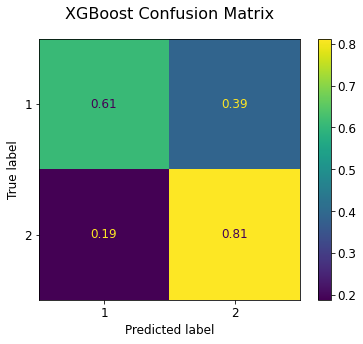

In [105]:
plot_confusion_matrix(xgb_search, X_test, y_test, normalize='true')
plt.title('XGBoost Confusion Matrix')
plt.savefig('./report/figures/plot_xgb_confmatrix.eps', bbox_inches='tight', dpi=300)
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


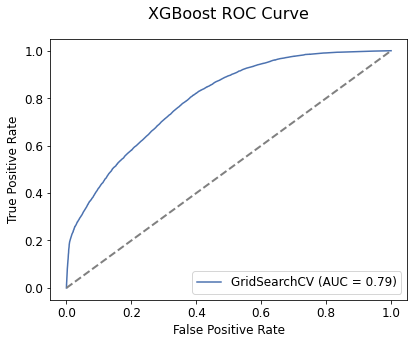

In [106]:
plot_roc_curve(xgb_search, X_test, y_test)
plt.plot([0, 1], [0, 1], '--', lw=2, color='grey')
plt.title('XGBoost ROC Curve')
plt.savefig('./report/figures/plot_xgb_roc.eps', bbox_inches='tight', dpi=300)
plt.show()

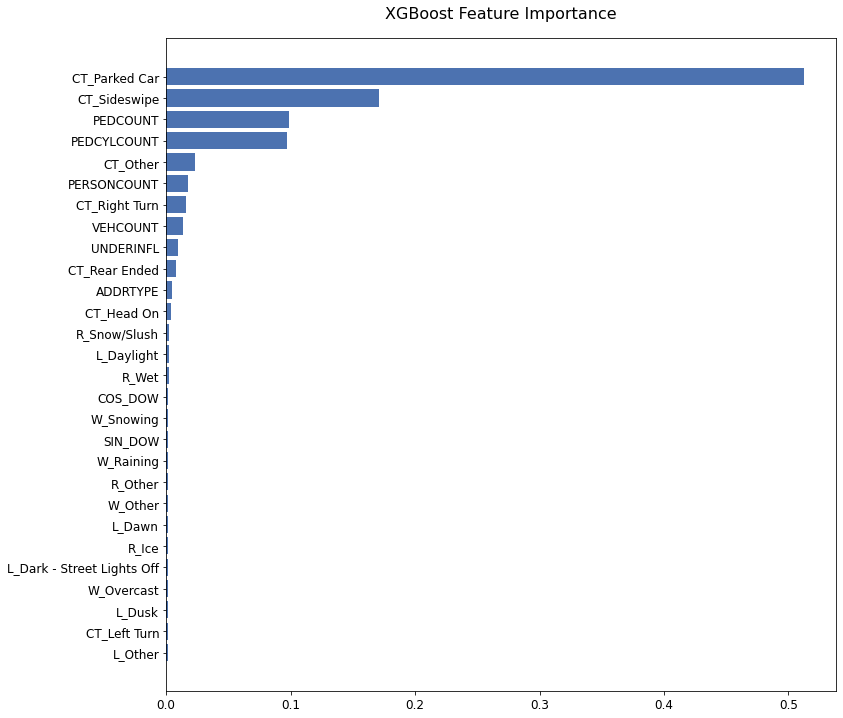

In [107]:
sorted_idx = xgb_search.best_estimator_.steps[-1][-1].feature_importances_.argsort()
plt.figure(figsize=(12, 12))
plt.barh(X.columns[sorted_idx], xgb_search.best_estimator_.steps[-1][-1].feature_importances_[sorted_idx])
plt.title('XGBoost Feature Importance')
plt.show()

In [108]:
explainer = shap.TreeExplainer(xgb_search.best_estimator_.steps[-1][-1])
shap_values = explainer.shap_values(X_test)

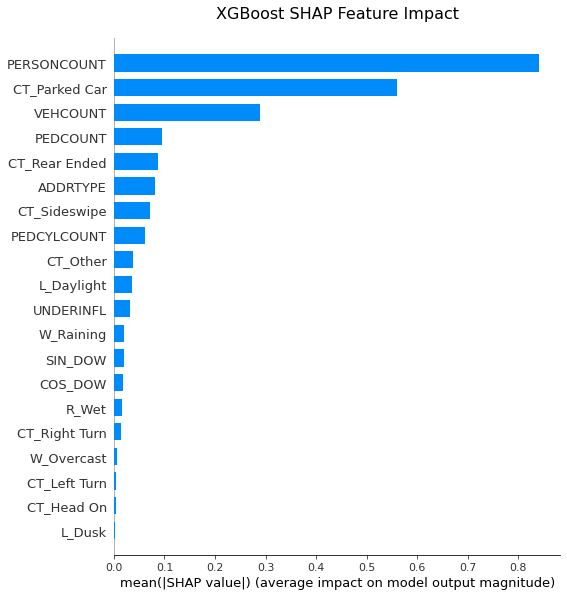

In [109]:
shap.summary_plot(shap_values, X_test, plot_type='bar', show=False)
plt.title('XGBoost SHAP Feature Impact')
plt.savefig('./report/figures/plot_shap_bar.eps', bbox_inches='tight', dpi=300)
plt.show()

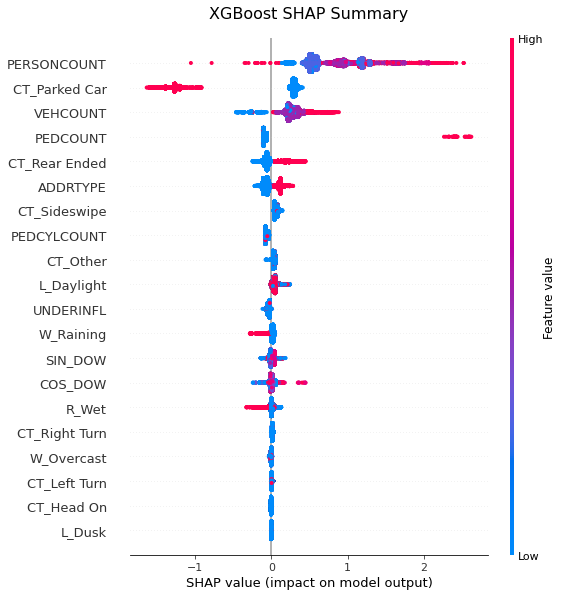

In [110]:
shap.summary_plot(shap_values, X_test, show=False)
plt.title('XGBoost SHAP Summary')
plt.savefig('./report/figures/plot_shap_beeswarm.eps', bbox_inches='tight', dpi=300)
plt.show()

## Results and Discussion <a name="results"></a>

All algorithms had similar performance. Imbalanced models had a better recall on average because it was better for the low severity accidents, but worse for high severity ones. Balanced models were better when predicting high severity.

Predicting road vehicle accident severity with open data is feasible. Feature engineering is a critical step in this process, that will have a big impact on the performance of the models and in its applicability for future predictions.

Although machine learning models are useful in predicting accident severity, in this study they rely only on data collected after the accident, making it difficult to make predictions beforehand. Also, only data about the city of Seattle was used, limiting the model usefulness as data from other cities might be in different formats, or the accident severity conditions might differ.


## Conclusion <a name="conclusion"></a>

In this study we analyzed the road vehicle collisions in the city of Seattle, identifying features that impact the severity of the accident. If it happens at an intersection, involves pedestrians or bicycles, happens to be a head on, rear ended or left turn collision, it is more likely to be severe. Peak hours and more movement on the streets means more accidents. We also built classification models to predict the accident severity based on the available data that were used to explain how the features impact severity, and can also be used to simulate different accident conditions.